<a href="https://colab.research.google.com/github/maggomor/adoption_project/blob/main/Final__Animal_Adoption.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assessing the likelihood of cats & dogs getting adopted

Whoever knows me, knows that I am an absolute animal lover, especially cats and dogs. Therefore, today I started looking into what kinds of factors may impact whether an animal in a shelter would get adopted.

I use the dataset kindly provided here: https://data.world/rdowns26/austin-animal-shelter 
It mainly utilises data from Austin Animal Shelters that is available online. I have provided it on my GitHub-Repository as well. Let's first import some basic packages as well as the data as used by the authors in the above project (and in their raw form).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
df = pd.read_csv("https://raw.githubusercontent.com/maggomor/adoption_project/main/all_records.csv")

outcome_df = pd.read_csv("https://raw.githubusercontent.com/maggomor/adoption_project/main/Austin_Animal_Center_Outcomes.csv")

intake_df = pd.read_csv("https://raw.githubusercontent.com/maggomor/adoption_project/main/Austin_Animal_Center_Intakes.csv")
df.shape, outcome_df.shape, intake_df.shape


((76977, 38), (63643, 12), (63328, 12))

When I first checked this, I felt that something was wrong in the data as provided by the authors. Using a dataset of intakes and outcomes both below 70k, they rose above 70k observations? That sparked my interest. Observe for example the data for a cute little kitty named "Mustachala":

In [2]:
df[df["Name_intake"]=="Mustachala"]

,Unnamed: 0,Animal ID,Name_intake,DateTime_intake,MonthYear_intake,Found_Location,Intake_Type,IntakeCondition,Animal_Type_intake,Sex,...,beagle,terrier,boxer,poodle,rottweiler,dachshund,chihuahua,pit bull,DateTime_length,Days_length
5,5,A683798,Mustachala,2016-07-21 12:16:00,07/21/2016 12:16:00 PM,3118 Windsor Rd in Austin (TX),Stray,Normal,Cat,Spayed Female,...,0,0,0,0,0,0,0,0,88 days 22:39:00.000000000,12 weeks - 6 months
6,6,A683798,Mustachala,2016-07-21 12:16:00,07/21/2016 12:16:00 PM,3118 Windsor Rd in Austin (TX),Stray,Normal,Cat,Spayed Female,...,0,0,0,0,0,0,0,0,-729 days +05:50:00.000000000,NaN
7,7,A683798,Mustachala,2014-07-15 15:38:00,07/15/2014 03:38:00 PM,Austin (TX),Owner Surrender,Normal,Cat,Intact Female,...,0,0,0,0,0,0,0,0,825 days 19:17:00.000000000,2+ years
8,8,A683798,Mustachala,2014-07-15 15:38:00,07/15/2014 03:38:00 PM,Austin (TX),Owner Surrender,Normal,Cat,Intact Female,...,0,0,0,0,0,0,0,0,8 days 02:28:00.000000000,1-3 weeks


In [3]:
df[df["Name_intake"]=="Mustachala"][["DateTime_intake", "Found_Location", "Intake_Type", "Sex", "DateTime_outcome", "Outcome_Type"]]

,DateTime_intake,Found_Location,Intake_Type,Sex,DateTime_outcome,Outcome_Type
5,2016-07-21 12:16:00,3118 Windsor Rd in Austin (TX),Stray,Spayed Female,2016-10-18 10:55:00,Adoption
6,2016-07-21 12:16:00,3118 Windsor Rd in Austin (TX),Stray,Spayed Female,2014-07-23 18:06:00,Adoption
7,2014-07-15 15:38:00,Austin (TX),Owner Surrender,Intact Female,2016-10-18 10:55:00,Adoption
8,2014-07-15 15:38:00,Austin (TX),Owner Surrender,Intact Female,2014-07-23 18:06:00,Adoption


Clearly, we see that this is duplicate data stemming from a bad merge. Mustachala was clearly first taken in on 15th of June 2014 as surrendered by her owner as an intact female. She was then adopted a week later on 23rd of July but it seems that her will for freedom was stronger. She was recaptured in July 2016, this time now as a stray, but spayed female, and got readopted roughly 3 months later. Only heaven knows what journey Mustachala is on now, but we know at least that these are not supposed to be four distinct observations but two that were poorly merged. 
Therefore I decided to clean the raw data (which was kindly provided too) myself and do my own analysis on it. This is the result. Let's start with some data cleaning.

# 1 Data Cleaning 

Let's begin by dropping some duplicates. An animal that was registered with the same ID, Name, and DateTime, is surely a duplicate observation. Let's also rename the columns for the animal's sex so that we can save some typing. Finally, observe that there are *a lot* of different animal names:

In [4]:
intake_columns = intake_df.columns
outcome_columns = outcome_df.columns

intake_df.drop_duplicates(subset=['Animal ID', 'Name', 'DateTime'])
outcome_df.drop_duplicates(subset=['Animal ID', 'Name', 'DateTime'])
intake_df = intake_df.rename(columns={"Sex upon Intake":"Sex"})
outcome_df = outcome_df.rename(columns={"Sex upon Outcome":"Sex"})
len(intake_df["Name"].unique()), len(outcome_df["Name"].unique())

(12653, 12699)

In particular, observe that about 30% of intaken animals are nameless:

In [5]:
intake_df["Name"].isna().sum()/intake_df.shape[0]

0.30351503284487114

With 12,000 unique names, yet missing-values making up 30% of them, I figured that individual names are not going to give us a lot of information. However, the information on whether an animal is given a (or has a recorded) name might make a difference. I therefore decided to only keep names recorded on intake and drop it from the outcome_df:

In [6]:
outcome_df.drop("Name", axis = 1)


,Animal ID,DateTime,MonthYear,Date of Birth,Outcome Type,Outcome Subtype,Animal Type,Sex,Age upon Outcome,Breed,Color
0,A741715,01/11/2017 06:17:00 PM,01/11/2017 06:17:00 PM,03/07/2016,Adoption,NaN,Cat,Spayed Female,10 months,Domestic Shorthair Mix,Calico
1,A658751,11/13/2016 01:38:00 PM,11/13/2016 01:38:00 PM,07/14/2011,Return to Owner,NaN,Dog,Neutered Male,5 years,Border Terrier Mix,Tan
2,A721285,02/24/2016 02:42:00 PM,02/24/2016 02:42:00 PM,02/24/2014,Euthanasia,Suffering,Other,Unknown,2 years,Raccoon Mix,Black/Gray
3,A707443,07/13/2015 01:50:00 PM,07/13/2015 01:50:00 PM,06/21/2015,Transfer,Partner,Cat,Intact Female,3 weeks,Domestic Longhair Mix,Black Smoke
4,A684346,07/22/2014 04:04:00 PM,07/22/2014 04:04:00 PM,07/07/2014,Transfer,Partner,Cat,Intact Male,2 weeks,Domestic Shorthair Mix,Orange Tabby
...,...,...,...,...,...,...,...,...,...,...,...
63638,A746467,04/08/2017 01:27:00 PM,04/08/2017 01:27:00 PM,01/27/2017,Adoption,NaN,Dog,Spayed Female,2 months,Basset Hound Mix,White/Brown
63639,A746347,04/08/2017 01:28:00 PM,04/08/2017 01:28:00 PM,10/01/2016,Adoption,Offsite,Dog,Neutered Male,6 months,Pit Bull Mix,Brown/White
63640,A741868,04/08/2017 01:35:00 PM,04/08/2017 01:35:00 PM,11/03/2016,Return to Owner,NaN,Dog,Neutered Male,5 months,Labrador Retriever/Pit Bull,Black/White
63641,A746072,04/01/2017 06:50:00 PM,04/01/2017 06:50:00 PM,03/28/2015,Adoption,NaN,Dog,Neutered Male,2 years,German Shepherd Mix,Black/Tan


Next, we merge the data on Animal ID, Animal Type, Breed, Color, and Sex. That should guarantee us that we do not end up with many duplicates, but out of caution we will anyhow drop any duplicate observations containing both the same Animal ID and DateTime on Intake: they will be doubled.
We rename the "Name_x" column to "Name" and select only those variables that can plausibly be relevant (e.g. getting rid of Animal ID, among others):

In [7]:
merge_df = intake_df.merge(outcome_df, left_on=["Animal ID", "Animal Type", "Breed", "Color", "Sex"], right_on=["Animal ID", "Animal Type", "Breed", "Color", "Sex"])

merge_df = merge_df.drop_duplicates(subset=['Animal ID', 'DateTime_x'])
merge_df = merge_df.rename(columns = {"Name_x":"Name"})

X = merge_df[["Name","DateTime_x", "MonthYear_x", "Intake Type", "Intake Condition", "Animal Type", "Sex", "Age upon Intake", "Breed", "Color", "DateTime_y", "MonthYear_y", "Date of Birth", "Outcome Type", "Outcome Subtype", "Age upon Outcome"]]

Observe that one possible "Intake Type" is "Requested Euthanasia". From all animals (240) of this type, almost all were either killed, died, or transferred:

In [8]:
X[X["Intake Type"]=="Euthanasia Request"]["Outcome Type"].value_counts()[:5].sort_values(ascending=False)

Euthanasia         188
Transfer            27
Adoption            13
Return to Owner      9
Died                 3
Name: Outcome Type, dtype: int64

We will therefore exclude Intake Type "Euthanasia Request" because it will almost surely end in a dead animal anyhow. We are more interested in animals that have a shot of making it.
Next, let's only keep those animals that were not set up for euthanasia, and we code a dummy variable for whether the name of an animal is missing.

In [9]:
X = X[X["Intake Type"].isin(["Stray","Wildlife", "Owner Surrender", "Public Assist"])]

X_temp = pd.get_dummies(X, columns= ["Name"], dummy_na = True)
X_new = X_temp[["Name_nan", "DateTime_x", "MonthYear_x", "Intake Type", "Intake Condition", "Animal Type", "Sex", "Age upon Intake", "Breed", "Color", "DateTime_y", "MonthYear_y", "Date of Birth", "Outcome Type", "Outcome Subtype", "Age upon Outcome"]]


Next, observe that this dataset also contains data on birds, livestock, or "Other":

In [10]:
X_new[X_new["Animal Type"]=="Other"].head()

,Name_nan,DateTime_x,MonthYear_x,Intake Type,Intake Condition,Animal Type,Sex,Age upon Intake,Breed,Color,DateTime_y,MonthYear_y,Date of Birth,Outcome Type,Outcome Subtype,Age upon Outcome
6,1,01/18/2015 06:18:00 PM,01/18/2015 06:18:00 PM,Wildlife,Sick,Other,Unknown,6 months,Opossum Mix,Gray,01/18/2015 06:33:00 PM,01/18/2015 06:33:00 PM,07/18/2014,Euthanasia,Medical,6 months
19,1,08/26/2016 04:12:00 PM,08/26/2016 04:12:00 PM,Wildlife,Normal,Other,Unknown,1 year,Raccoon Mix,Gray,08/28/2016 09:03:00 AM,08/28/2016 09:03:00 AM,08/26/2015,Euthanasia,Rabies Risk,1 year
26,1,10/26/2015 05:37:00 PM,10/26/2015 05:37:00 PM,Owner Surrender,Normal,Other,Unknown,6 months,Hamster Mix,Gray/White,10/27/2015 02:55:00 PM,10/27/2015 02:55:00 PM,04/26/2015,Transfer,Partner,6 months
30,1,03/17/2016 02:41:00 PM,03/17/2016 02:41:00 PM,Wildlife,Injured,Other,Unknown,1 year,Opossum Mix,Gray/White,03/17/2016 03:01:00 PM,03/17/2016 03:01:00 PM,03/17/2015,Euthanasia,Suffering,1 year
53,1,02/25/2017 02:44:00 PM,02/25/2017 02:44:00 PM,Stray,Normal,Other,Intact Female,1 year,Havana Mix,Black,02/28/2017 09:01:00 AM,02/28/2017 09:01:00 AM,02/25/2016,Transfer,Partner,1 year


In [11]:
X_new[X_new["Animal Type"]=="Livestock"].head()

,Name_nan,DateTime_x,MonthYear_x,Intake Type,Intake Condition,Animal Type,Sex,Age upon Intake,Breed,Color,DateTime_y,MonthYear_y,Date of Birth,Outcome Type,Outcome Subtype,Age upon Outcome
6818,1,02/28/2014 11:06:00 AM,02/28/2014 11:06:00 AM,Stray,Normal,Livestock,Neutered Male,1 year,Pig Mix,Black/White,03/11/2014 02:39:00 PM,03/11/2014 02:39:00 PM,02/28/2013,Adoption,Foster,1 year
15370,1,01/09/2016 12:14:00 PM,01/09/2016 12:14:00 PM,Stray,Normal,Livestock,Intact Male,1 year,Pig Mix,White,01/27/2016 12:00:00 AM,01/27/2016 12:00:00 AM,01/09/2015,Transfer,Partner,1 year
24587,1,01/17/2017 12:22:00 PM,01/17/2017 12:22:00 PM,Owner Surrender,Normal,Livestock,Intact Female,6 months,Potbelly Pig Mix,Black/White,03/15/2017 12:49:00 PM,03/15/2017 12:49:00 PM,07/17/2016,Transfer,Partner,7 months
36309,1,03/09/2014 04:45:00 PM,03/09/2014 04:45:00 PM,Stray,Normal,Livestock,Unknown,2 weeks,Pig Mix,Black,03/29/2014 02:00:00 PM,03/29/2014 02:00:00 PM,02/22/2014,Adoption,Foster,5 weeks
38137,1,05/22/2014 02:22:00 PM,05/22/2014 02:22:00 PM,Stray,Normal,Livestock,Intact Male,5 months,Goat Mix,Black,06/17/2014 10:30:00 AM,06/17/2014 10:30:00 AM,11/22/2013,Transfer,Partner,6 months


Since Opossums or Raccoons (see column "Breed") hardly have a shot at being adopted, let's rather just focus on dogs and cats. They will most likely be adopted by rather similar criteria, whereas an oppossum, a bat, or a pig might be adopted on other grounds (although I hear some people have house pigs and that kind of makes me want to get one).

In [12]:
cats_dogs_df = X_new[X_new["Animal Type"].isin(["Cat", "Dog"])]

Next, let's see how animals fare:

In [13]:
print(cats_dogs_df[cats_dogs_df["Outcome Type"] == "Euthanasia"].shape[0]/cats_dogs_df.shape[0], cats_dogs_df[cats_dogs_df["Outcome Type"] == "Adoption"].shape[0]/cats_dogs_df.shape[0])

0.06369876557159403 0.2242592017174656


6% of animals suffer Euthanasia, whereas 22% get adopted. Let's get the entire descriptive statistics:

In [14]:
cats_dogs_df["Outcome Type"].value_counts().sort_values(ascending=False)

Transfer           14866
Return to Owner     9874
Adoption            7939
Euthanasia          2255
Died                 407
Missing               32
Disposal              20
Rto-Adopt              8
Name: Outcome Type, dtype: int64

Let's see some plots how this relates

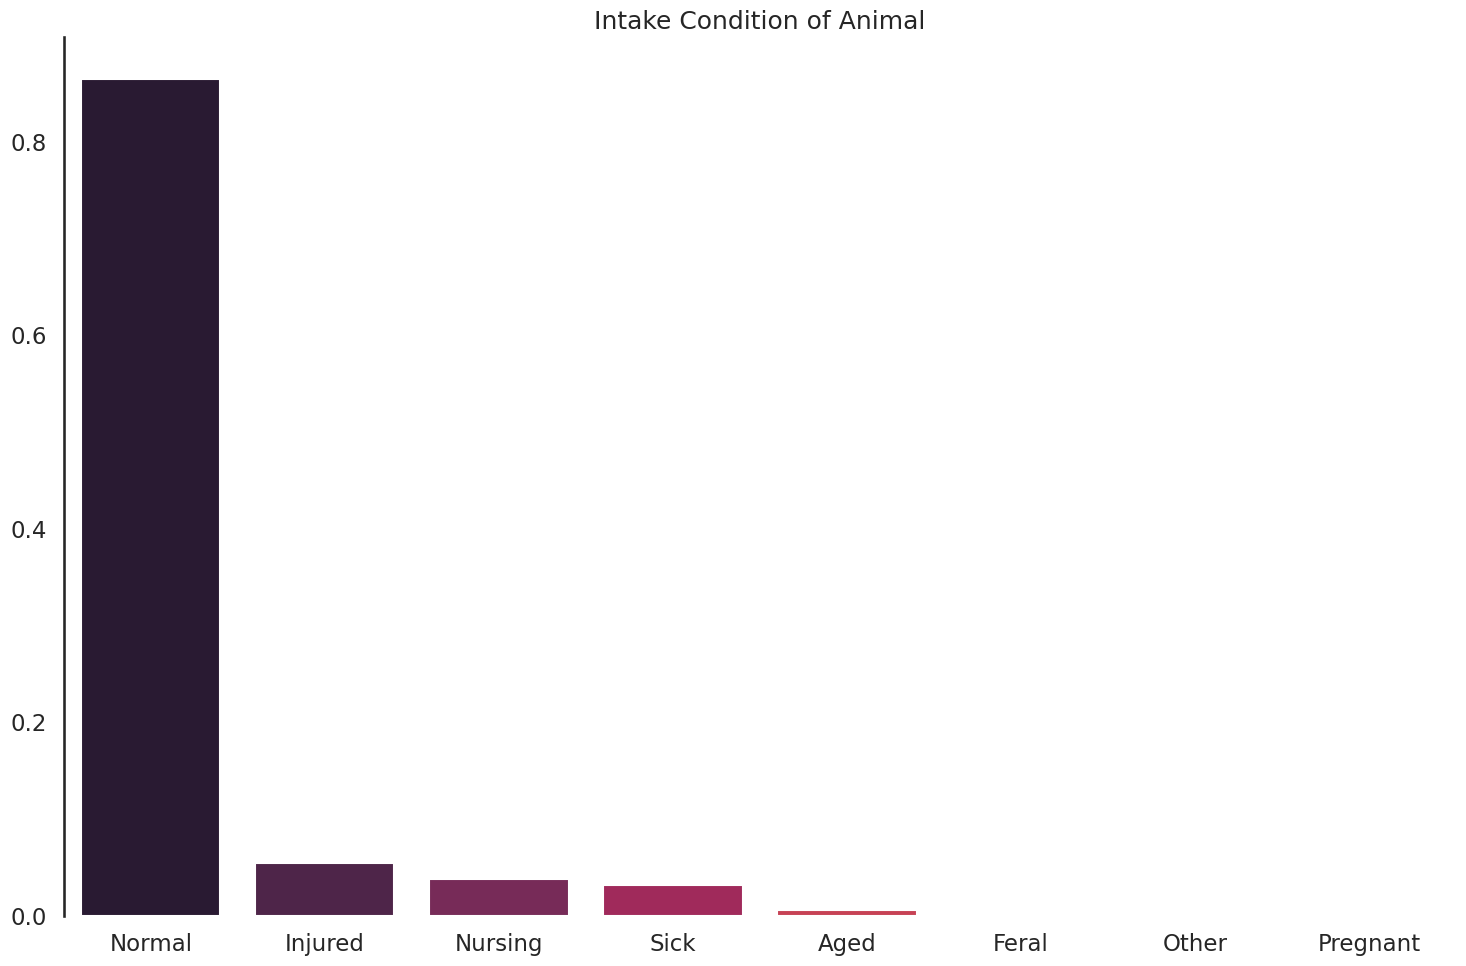

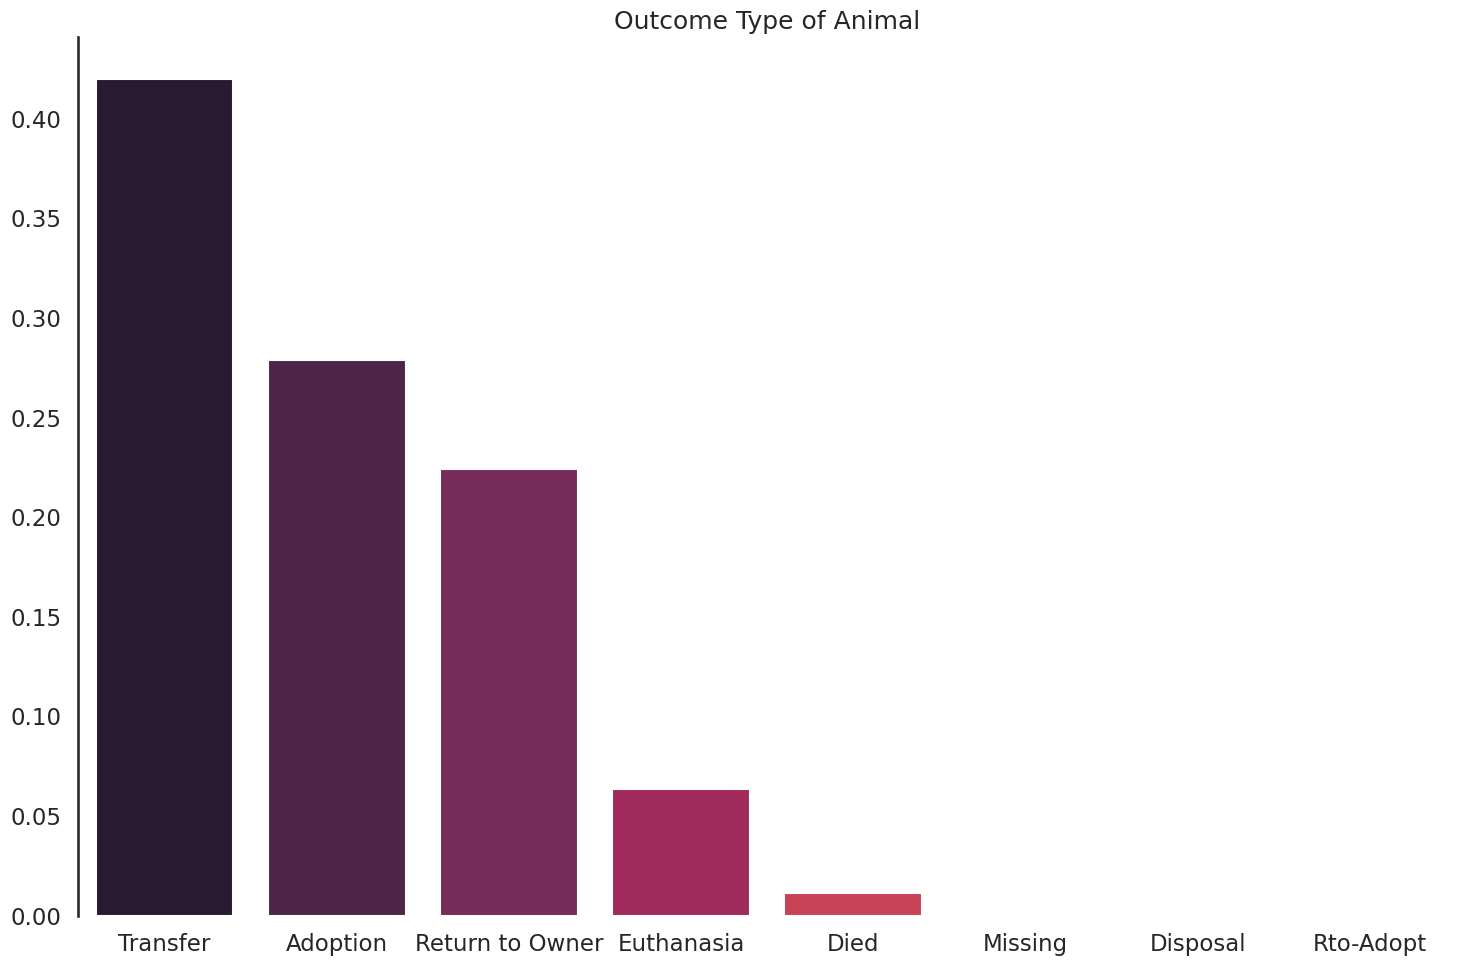

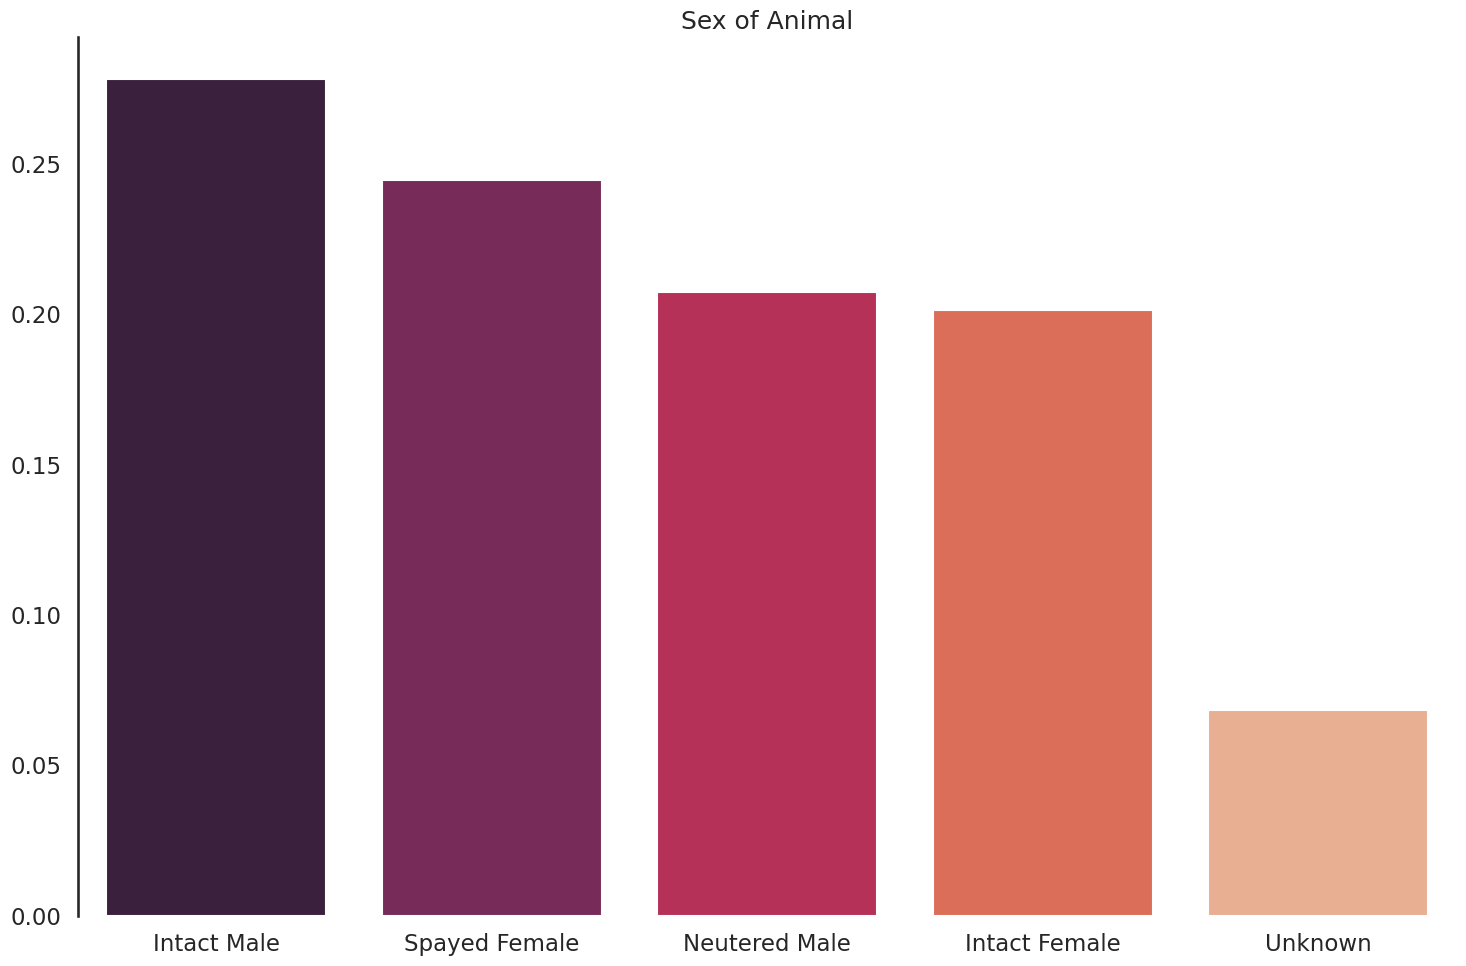

In [15]:
sns.set_theme(style="white", context="talk")

# Set up the matplotlib figure
f = plt.figure(figsize=(15, 10))

# Generate some sequential data
x = np.array(cats_dogs_df["Intake Condition"].unique())
y1 = np.array(cats_dogs_df["Intake Condition"].value_counts()/cats_dogs_df.shape[0])
sns.barplot(x=x, y=y1, palette="rocket")
plt.title("Intake Condition of Animal")
sns.despine(bottom=True)
#plt.setp(f.axes, yticks=[])
plt.tight_layout(h_pad=2)

#plt.clf()

f = plt.figure(figsize=(15, 10))

# Randomly reorder the data to make it qualitative
x = np.array(cats_dogs_df["Outcome Type"].unique())
y3 = np.array(cats_dogs_df["Outcome Type"].value_counts()/cats_dogs_df.shape[0])

sns.barplot(x=x, y=y3, palette="rocket")
plt.title("Outcome Type of Animal")

# Finalize the plot
sns.despine(bottom=True)
#plt.setp(f.axes, yticks=[])
plt.tight_layout(h_pad=2)


f = plt.figure(figsize=(15, 10))

# Generate some sequential data
x = np.array(cats_dogs_df["Sex"].dropna().unique())
y1 = np.array(cats_dogs_df["Sex"].value_counts()/cats_dogs_df.shape[0])

plt.title("Sex of Animal")

sns.barplot(x=x, y=y1, palette="rocket")
sns.despine(bottom=True)
#plt.setp(f.axes, yticks=[])
plt.tight_layout(h_pad=2)

#plt.clf()

The most common case is "Transfer" (making up more than half the dataset). That's not good because we do not know how animals fare at their new shelter. We therefore drop them as well as missing outcomes. Next, the age-category is coded as a lot of different strings, mainly encoded as years, but sometimes taking on values of "weeks" or even "days". We will recode them as "0 years" (i.e. less than one year). In order to make sure we work with clean data I also perform the same for the outcome-age and keep only those were the difference between outcome-age and intake-age is non-negative (to ensure reliable data).

In [16]:
df3 = cats_dogs_df[cats_dogs_df["Outcome Type"].isin(["Adoption", "Return to Owner", "Euthanasia", "Died", "Disposal", "Rto-Adopt"])]

df3[df3["Age upon Intake"].isin(["1 month", "1 weeks", "9 months", "3 months", "2 months", "10 months", "7 months", "4 months", "11 months", "6 months", "3 weeks", "8 months", "5 months", "2 weeks", "2 days", "1 day", "4 weeks", "1 week", "3 days", "6 days", "5 weeks", "4 days", "5 days"])]["Age upon Intake"] = "0 years"
df3["Age upon Intake"] = df3["Age upon Intake"].apply(lambda x: x.split(" ")[0])
df3["Age upon Intake"] = df3["Age upon Intake"].apply(lambda x: int(x))
df3[df3["Age upon Outcome"].isin(["1 month", "1 weeks", "9 months", "3 months", "2 months", "10 months", "7 months", "4 months", "11 months", "6 months", "3 weeks", "8 months", "5 months", "2 weeks", "2 days", "1 day", "4 weeks", "1 week", "3 days", "6 days", "5 weeks", "4 days", "5 days"])]["Age upon Outcome"] = "0 years"
df3 = df3.dropna(subset = ["Age upon Outcome"])
df3["Age upon Outcome"] = df3["Age upon Outcome"].apply(lambda x: x.split(" ")[0])
df3["Age upon Outcome"] = df3["Age upon Outcome"].apply(lambda x: int(x))

df3["years_spent"] = df3["Age upon Outcome"] - df3["Age upon Intake"]
df4 = df3[df3["years_spent"]>=0]
df4 = df4.rename(columns = {"Age upon Intake":"age_intake"})

<ipython-input-16-44a4ea331766>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3[df3["Age upon Intake"].isin(["1 month", "1 weeks", "9 months", "3 months", "2 months", "10 months", "7 months", "4 months", "11 months", "6 months", "3 weeks", "8 months", "5 months", "2 weeks", "2 days", "1 day", "4 weeks", "1 week", "3 days", "6 days", "5 weeks", "4 days", "5 days"])]["Age upon Intake"] = "0 years"
<ipython-input-16-44a4ea331766>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3["Age upon Intake"] = df

Let's see how we fare only for cats and dogs that were not transferred.

In [17]:
cats_dogs_df2 = cats_dogs_df[cats_dogs_df["Outcome Type"].isin(["Adoption", "Return to Owner", "Rto-Adopt", "Euthanasia", "Died", "Disposal"])]
cats_dogs_df2["Intake Condition"].value_counts(), cats_dogs_df2["Intake Type"].value_counts(), cats_dogs_df2["Sex"].value_counts(), cats_dogs_df2["Outcome Type"].value_counts()

(Normal      18060
 Injured      1408
 Sick          681
 Aged          168
 Nursing       137
 Other          32
 Feral           9
 Pregnant        8
 Name: Intake Condition, dtype: int64,
 Stray              12608
 Owner Surrender     5418
 Public Assist       2477
 Name: Intake Type, dtype: int64,
 Neutered Male    7983
 Spayed Female    6990
 Intact Male      2954
 Intact Female    2295
 Unknown           280
 Name: Sex, dtype: int64,
 Return to Owner    9874
 Adoption           7939
 Euthanasia         2255
 Died                407
 Disposal             20
 Rto-Adopt             8
 Name: Outcome Type, dtype: int64)

In [18]:
df4.head()

,Name_nan,DateTime_x,MonthYear_x,Intake Type,Intake Condition,Animal Type,Sex,age_intake,Breed,Color,DateTime_y,MonthYear_y,Date of Birth,Outcome Type,Outcome Subtype,Age upon Outcome,years_spent
1,0,07/21/2016 12:16:00 PM,07/21/2016 12:16:00 PM,Stray,Normal,Cat,Spayed Female,3,Domestic Medium Hair Mix,White/Black,10/18/2016 10:55:00 AM,10/18/2016 10:55:00 AM,01/15/2013,Adoption,Foster,3,0
7,1,10/05/2013 01:43:00 PM,10/05/2013 01:43:00 PM,Owner Surrender,Normal,Cat,Spayed Female,2,Domestic Shorthair Mix,Torbie,10/10/2013 02:07:00 PM,10/10/2013 02:07:00 PM,10/05/2011,Adoption,NaN,2,0
8,0,05/21/2016 04:30:00 PM,05/21/2016 04:30:00 PM,Stray,Normal,Cat,Intact Male,1,Domestic Shorthair Mix,Brown Tabby,06/14/2016 04:18:00 PM,06/14/2016 04:18:00 PM,04/09/2016,Adoption,NaN,2,1
9,0,04/23/2016 11:28:00 AM,04/23/2016 11:28:00 AM,Owner Surrender,Normal,Cat,Neutered Male,1,Domestic Shorthair Mix,Brown Tabby/White,04/23/2016 04:48:00 PM,04/23/2016 04:48:00 PM,04/23/2015,Adoption,NaN,1,0
11,0,01/24/2014 02:54:00 PM,01/24/2014 02:54:00 PM,Public Assist,Normal,Dog,Neutered Male,3,Pekingese Mix,Brown/White,02/04/2014 11:11:00 AM,02/04/2014 11:11:00 AM,01/24/2011,Return to Owner,NaN,3,0


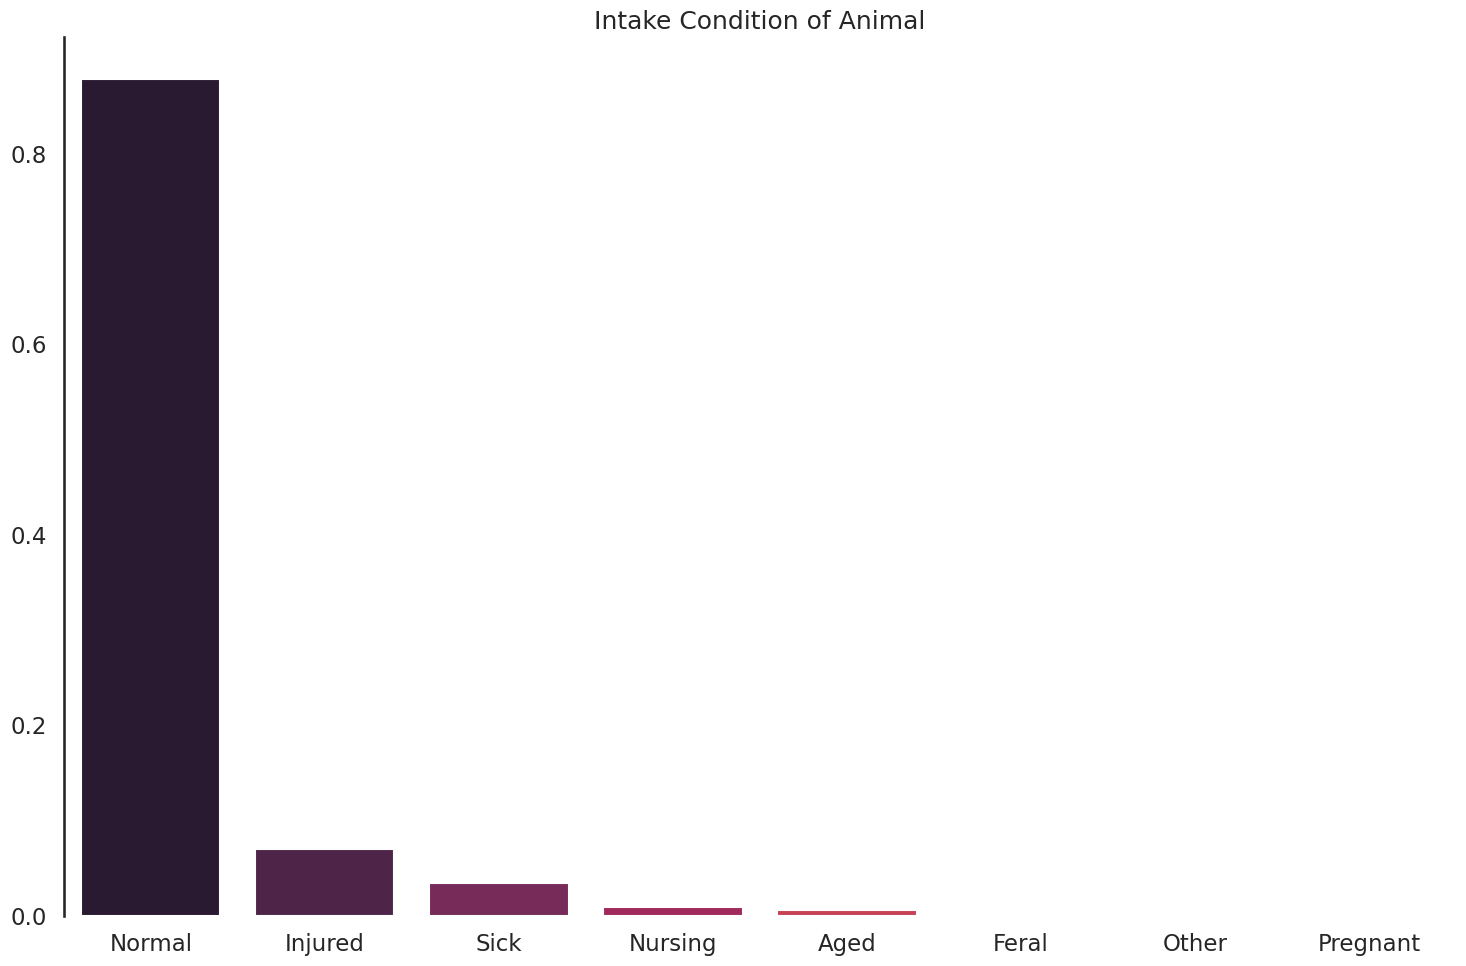

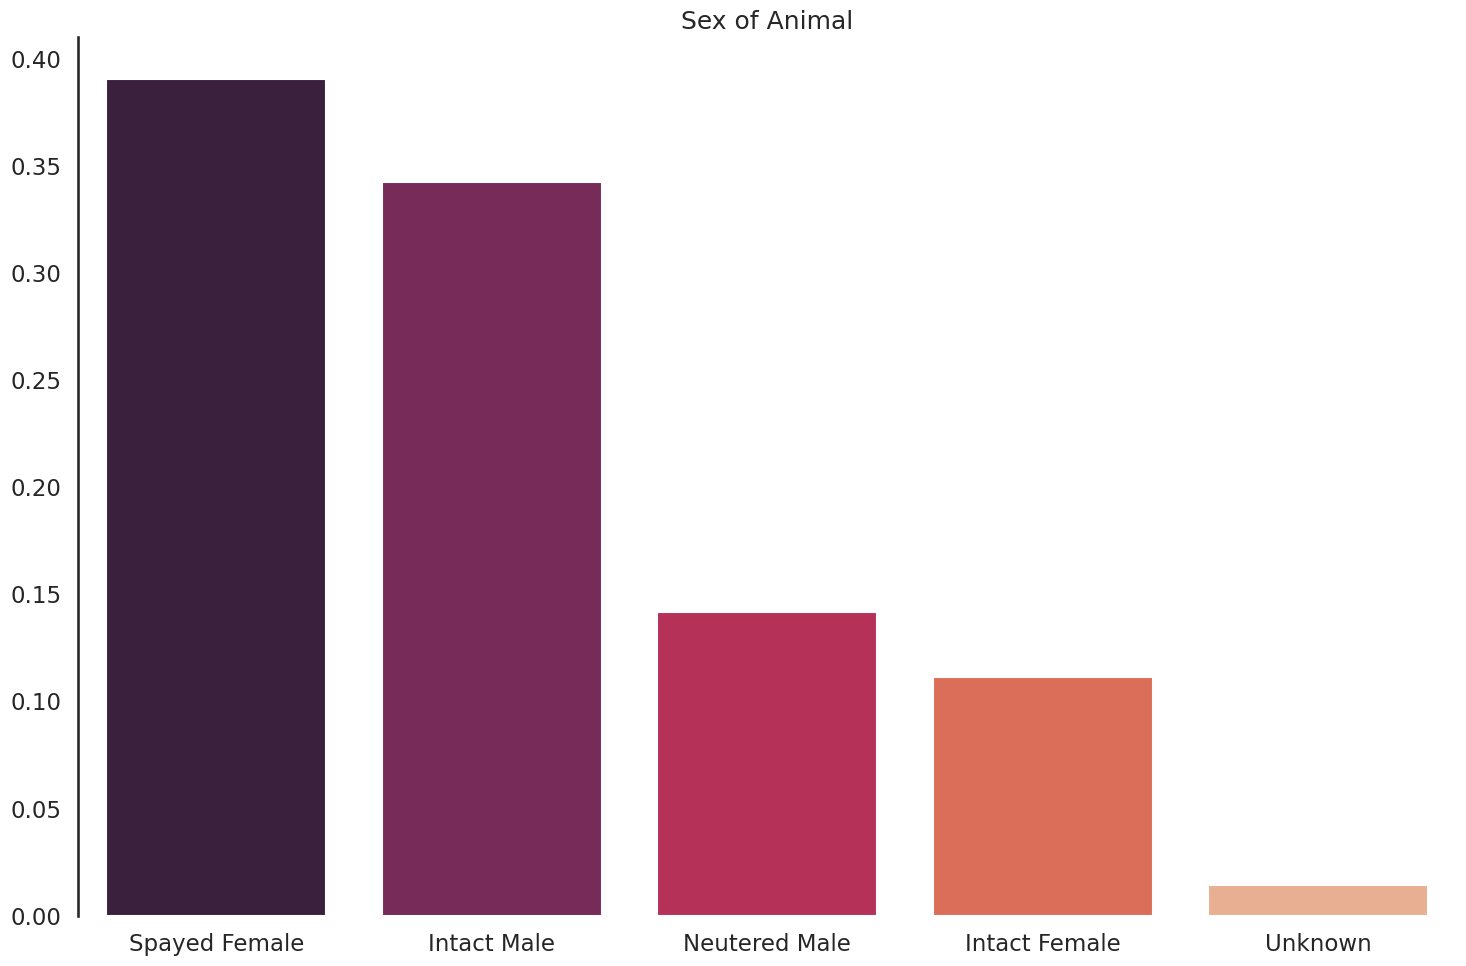

In [19]:
sns.set_theme(style="white", context="talk")

# Set up the matplotlib figure
f = plt.figure(figsize=(15, 10))

# Generate some sequential data
x = np.array(df4["Intake Condition"].unique())
y1 = np.array(df4["Intake Condition"].value_counts()/df4.shape[0])
sns.barplot(x=x, y=y1, palette="rocket")
plt.title("Intake Condition of Animal")
sns.despine(bottom=True)
#plt.setp(f.axes, yticks=[])
plt.tight_layout(h_pad=2)




f = plt.figure(figsize=(15, 10))

# Generate some sequential data
x = np.array(df4["Sex"].dropna().unique())
y1 = np.array(df4["Sex"].value_counts()/df4.shape[0])

plt.title("Sex of Animal")

sns.barplot(x=x, y=y1, palette="rocket")
sns.despine(bottom=True)
#plt.setp(f.axes, yticks=[])
plt.tight_layout(h_pad=2)

#plt.clf()



We see that a) only around 2% of all animals have unknown sex, so we will drop them in favour of tractability of results (and because of possible confounders). There is also exactly one observation with "NaN"-Sex, we will drop it too. Also, almost all cats and dogs are admitted in normal condition, whereas nearly no observations are nursing, aged, other, pregnant or feral. It therefore make sense to recode that variable as intake-condition: normal / not-normal.

In [20]:
df4 = df4[df4["Sex"].isin(["Spayed Female", "Intact Male", "Neutered Male", "Intact Female"])]

df4["Normal Condition"] = np.where(df4["Intake Condition"]=="Normal",1,0)

<ipython-input-20-0f7844d3cc9b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df4["Normal Condition"] = np.where(df4["Intake Condition"]=="Normal",1,0)


In [21]:
df4["Sex"].unique(), df4["Normal Condition"].unique(), df4["Intake Type"].unique(), df4["Animal Type"].unique()

(array(['Spayed Female', 'Intact Male', 'Neutered Male', 'Intact Female'],
       dtype=object),
 array([1, 0]),
 array(['Stray', 'Owner Surrender', 'Public Assist'], dtype=object),
 array(['Cat', 'Dog'], dtype=object))

Finally, we will one-hot-encode the variables "Sex", "Animal Type", and "Intake Type".

In [22]:
df4 = pd.get_dummies(data = df4, columns = ["Intake Type", "Animal Type", "Sex"])

In [23]:
df4.columns

Index(['Name_nan', 'DateTime_x', 'MonthYear_x', 'Intake Condition',
       'age_intake', 'Breed', 'Color', 'DateTime_y', 'MonthYear_y',
       'Date of Birth', 'Outcome Type', 'Outcome Subtype', 'Age upon Outcome',
       'years_spent', 'Normal Condition', 'Intake Type_Owner Surrender',
       'Intake Type_Public Assist', 'Intake Type_Stray', 'Animal Type_Cat',
       'Animal Type_Dog', 'Sex_Intact Female', 'Sex_Intact Male',
       'Sex_Neutered Male', 'Sex_Spayed Female'],
      dtype='object')

Next, we only keep the dummy-variables for "Name is missing", the different intake-types, intake-conditions, animal-type, sex-type, and age at intake. For the outcome variable "y_regression" we encode a "good" versus a "bad" outcome: an animal being returned to their owner, adopted, or having "Rto-Adopt" (Return-Adoption) will be counted as "1", a killed, dead, or disposed animal will be a "0".

In [24]:

X_regression = df4[["Name_nan","age_intake", "Normal Condition","Intake Type_Owner Surrender", "Intake Type_Public Assist", "Intake Type_Stray", "Animal Type_Dog", "Sex_Intact Female", "Sex_Intact Male", "Sex_Neutered Male", "Sex_Spayed Female"]]
y = df4[["Outcome Type", "Outcome Subtype"]]
y_regression = y["Outcome Type"].isin(["Adoption", "Return to Owner", "Rto-Adopt"])
y_regression = np.where(y_regression, 1, 0)

In [25]:
X_regression.head()

,Name_nan,age_intake,Normal Condition,Intake Type_Owner Surrender,Intake Type_Public Assist,Intake Type_Stray,Animal Type_Dog,Sex_Intact Female,Sex_Intact Male,Sex_Neutered Male,Sex_Spayed Female
1,0,3,1,0,0,1,0,0,0,0,1
7,1,2,1,1,0,0,0,0,0,0,1
8,0,1,1,0,0,1,0,0,1,0,0
9,0,1,1,1,0,0,0,0,0,1,0
11,0,3,1,0,1,0,1,0,0,1,0


That concludes Data Cleaning and we can now go to the Learning-Phase of this project.

# 2 Predictive Inference

Let's first import some common classifiers to use and standardize the data that we use:

In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, recall_score, precision_score
from sklearn.model_selection import GridSearchCV

sc = StandardScaler()
sc_fit = sc.fit(X_regression)
X_transformer = sc_fit.transform(X_regression)
X_transformer.shape

(19057, 11)

Next, the train-test-split. A ratio of 80:20 seems good as we still have 19,000 observations.

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X_transformer, y_regression, test_size = 0.2, random_state = 36)

Let's fit all of these and see how good they are at prediction. We'll measure accuracy, the F1-score, Recall, and Precision, as well as the confusion matrix. In particular, let me first define a function to plot a rather nicer-looking confusion matrix:

In [28]:
def plot_confusion_matrix(y,y_predict):
    "this function plots the confusion matrix"
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y, y_predict)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True,fmt='d', ax = ax); #annot=True to annotate cells
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['Bad Outcome', 'Positive Outcome']); ax.yaxis.set_ticklabels(['Bad Outcome', 'Positive Outcome'])

SVM:
Accuracy: 0.939
F1-Score: 0.966
Recall: 0.989
Precision: 0.944


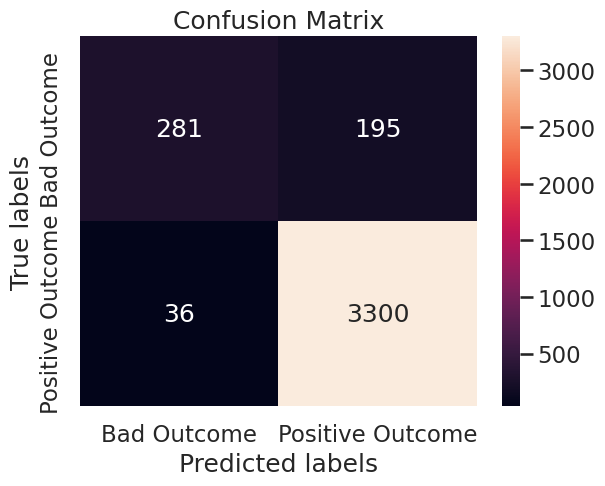

In [29]:
svm = SVC(kernel = "rbf")
clf = svm.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("SVM:")
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.3f}")
f_one = f1_score(y_test, y_pred)
print(f"F1-Score: {f_one:.3f}")
recall = recall_score(y_test, y_pred)
print(f"Recall: {recall:.3f}")
prec = precision_score(y_test, y_pred)
print(f"Precision: {prec:.3f}")
plot_confusion_matrix(y_test, y_pred)

A Support-Vector-Machine with gaussian kernel fares very well, it seems. Let us fit a couple others. Next up: a Cross-Validated KNN-approach:

KNN:
Accuracy: 0.934
F1-Score: 0.963
Recall: 0.986
Precision: 0.942


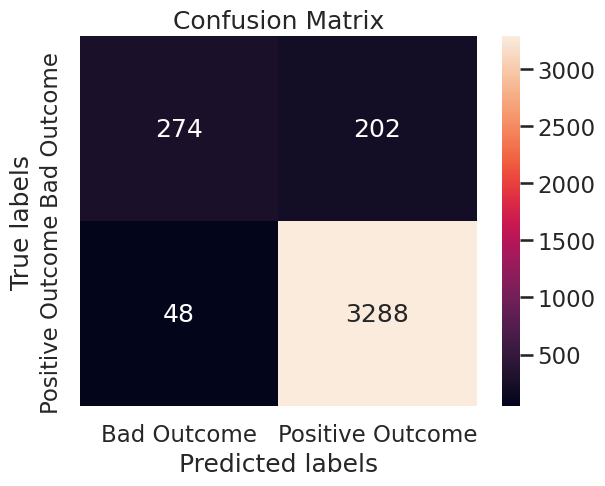

In [30]:
knn = KNeighborsClassifier()

parameters = {"n_neighbors": [3,5,7]}

knn_cv = GridSearchCV(knn, param_grid=parameters)

clf = knn_cv.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("KNN:")
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.3f}")
f_one = f1_score(y_test, y_pred)
print(f"F1-Score: {f_one:.3f}")
recall = recall_score(y_test, y_pred)
print(f"Recall: {recall:.3f}")
prec = precision_score(y_test, y_pred)
print(f"Precision: {prec:.3f}")
plot_confusion_matrix(y_test, y_pred)

KNN fares nearly identical. Next up: a Logistic Regression:

Logistic Regression:
Accuracy: 0.935
F1-Score: 0.963
Recall: 0.984
Precision: 0.944


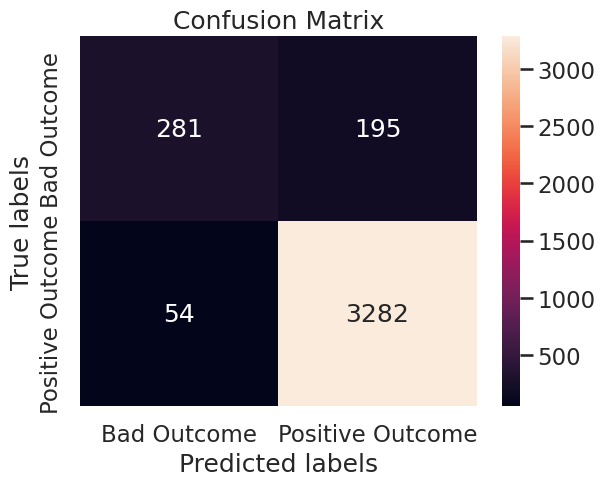

In [31]:
log_reg = LogisticRegression()

clf = log_reg.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("Logistic Regression:")
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.3f}")
f_one = f1_score(y_test, y_pred)
print(f"F1-Score: {f_one:.3f}")
recall = recall_score(y_test, y_pred)
print(f"Recall: {recall:.3f}")
prec = precision_score(y_test, y_pred)
print(f"Precision: {prec:.3f}")
plot_confusion_matrix(y_test, y_pred)

Not bad, but almost always a little bit worse. Next up: Random Forest!

Random Forest:
Accuracy: 0.936
F1-Score: 0.964
Recall: 0.982
Precision: 0.946


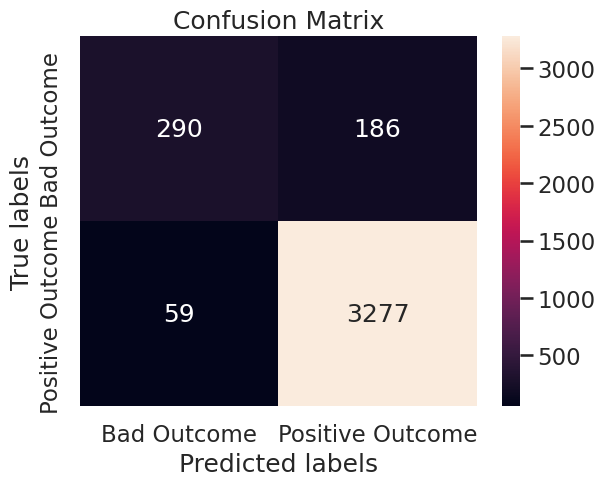

In [32]:
rf = RandomForestClassifier()

clf = rf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("Random Forest:")
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.3f}")
f_one = f1_score(y_test, y_pred)
print(f"F1-Score: {f_one:.3f}")
recall = recall_score(y_test, y_pred)
print(f"Recall: {recall:.3f}")
prec = precision_score(y_test, y_pred)
print(f"Precision: {prec:.3f}")
plot_confusion_matrix(y_test, y_pred)

Almost equal. Finally, a favorite of mine, let's take a voting-estimator over the SVM, KNN, and Random Forest:

Voting Classifier:
Accuracy: 0.938
F1-Score: 0.965
Recall: 0.985
Precision: 0.947


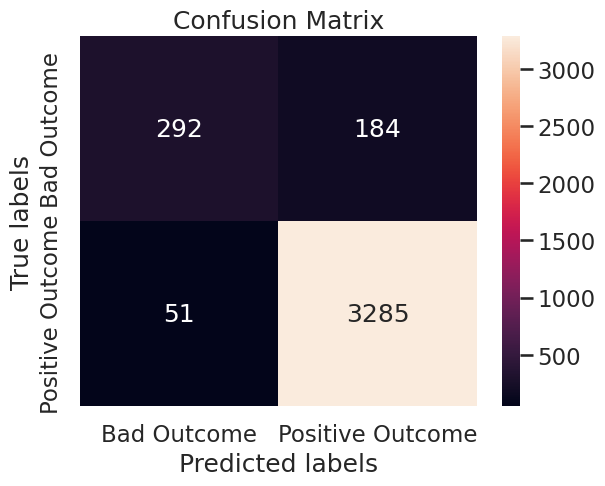

In [33]:
from sklearn.ensemble import VotingClassifier
voting_class = VotingClassifier(estimators = [("SVM", svm), ("KNN", knn), ("RF", rf)])

voting = voting_class.fit(X_train, y_train)
y_pred = voting.predict(X_test)
print("Voting Classifier:")
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.3f}")
f_one = f1_score(y_test, y_pred)
print(f"F1-Score: {f_one:.3f}")
recall = recall_score(y_test, y_pred)
print(f"Recall: {recall:.3f}")
prec = precision_score(y_test, y_pred)
print(f"Precision: {prec:.3f}")
plot_confusion_matrix(y_test, y_pred)

They all fare fairly well, but my personal favorite is the Voting-Classifier: by using a majority-rule over three well-performing Learners, we have a good chance that our final prediction will be fairly good - as the metrics indicate. 

# 3 Learning from the data

In [34]:
X_regression.columns

Index(['Name_nan', 'age_intake', 'Normal Condition',
       'Intake Type_Owner Surrender', 'Intake Type_Public Assist',
       'Intake Type_Stray', 'Animal Type_Dog', 'Sex_Intact Female',
       'Sex_Intact Male', 'Sex_Neutered Male', 'Sex_Spayed Female'],
      dtype='object')

What can we do next? Aside from the Age-Variable, nearly all of our features are 0-1-dummies. That does not lend itself too well for plotting or visualization exercises.
Instead, let us revisit my assumption from earlier on, namely that an absent name might be an interesting indicator for the animal's future. I have picked a rather unorthodox approach but one that I find fairly insightful. In particular, my interest lies in how much an animal having a name makes a difference for our prediction of them being adopted. For this, we'll generate synthetic data as follows.
Let us create a dataframe filled with artificial observations, one for each possible combination of all other features. For example, there will be exactly one 2-year-old neutered male dog brought in by the owner in normal condition, exactly one 7-year-old sex-intact-female cat brought in in abnormal condition, etc. Here is the code:

In [35]:
age_list = np.arange(0,20,1)

intake = ["Intake Type_Owner Surrender", "Intake Type_Public Assist", "Intake Type_Stray"]

condition = ["Normal Condition"]

animal = ["Animal Type_Dog"]
sex = ["Sex_Intact Female", "Sex_Intact Male", "Sex_Neutered Male", "Sex_Spayed Female"]


all_lists_dog = []
for i in intake:
    for c in condition:
        for a in animal:
            for s in sex:
                for age in age_list:
                    all_lists_dog.append([i, c, a, s, age])

This gives us a list in which each sublist specifies exactly one type of dog. Let's turn this into a dataframe:

In [36]:
columns = X_regression.columns
dog_df = pd.DataFrame(columns=columns)

for i in all_lists_dog:
    df2 = pd.DataFrame([[0]*dog_df.shape[1]],columns=dog_df.columns)
    for j in i[:-1]:
        df2[j] = 1 
    df2["age_intake"] = i[-1]
    dog_df = dog_df.append(df2, ignore_index=True)

<ipython-input-36-c529eb1030fc>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dog_df = dog_df.append(df2, ignore_index=True)


This way, each row in this dataframe has a 1 exactly where the list indicates, and finally for the age-column we give it the age-value of that possible, synthetic observation. Let's give them all a name and next clone this to adapt it for cats (i.e. "Animal Type_Dog" = 0):

In [37]:
dog_df["Name_nan"] = 0 
dog_df_abnormal = dog_df.copy(deep=True)
dog_df_abnormal["Normal Condition"] = 0

dog_df = pd.concat([dog_df, dog_df_abnormal], axis = 0)

cat_df = dog_df.copy(deep=True)
cat_df["Animal Type_Dog"] = 0

In [38]:
cat_df.shape

(480, 11)

Now we can combine these two to give us a full df for all cats and dogs with a name. Similarly, let us make a second synthetic, counterfactual dataframe, where all animals have no name (although they are no horses):

In [39]:
full_df = pd.concat([dog_df, cat_df], ignore_index=True)

full_df2 = pd.concat([dog_df, cat_df], ignore_index=True)
full_df2["Name_nan"] = 1

In [40]:
full_df.shape, full_df2.shape

((960, 11), (960, 11))

Next, we will pick a model (I choose the voting model but you can play around and instead use a different Learner) and make outcome-predictions (good or bad) for each of these synthetic datasets. We then append them to the initial DataFrame in which all animals have a name (full_df). Then we add a column that captures whether the prediction for a synthetic observation was altered by the fact that no name was given to the animal: 

In [41]:
model = voting

predicts = model.predict(sc_fit.transform(full_df))
predicts_change = model.predict(sc_fit.transform(full_df2))

full_df["predicts"] = predicts
full_df["predicts_change"] = predicts_change

full_df["change"] = full_df["predicts"] - full_df["predicts_change"]

Let's see what this gives us!

In [42]:
full_df["change"].value_counts().sort_values(ascending=False)

 1    481
 0    473
-1      6
Name: change, dtype: int64

In [43]:
full_df["change"].sum()/full_df["change"].shape[0]

0.4947916666666667

We see that for 50% of all combinations of animals, we *do* get a difference in outcome that is driven by the animal being named. Also, 5 observations predict that an animal would not be adopted with a name but would without a name. However, 5 out of 960 possible combinations is likely not very relevant and a statistical artifact. 
This result is already fairly interesting, but perhaps we can dig deeper. Perhaps an animal's outcome-change by giving it a name is also affected by other covariates. Let's see for which animals this is most severe.

In [44]:
change_df = full_df[full_df["change"]==1]
change_df = change_df.drop(["Name_nan", "predicts", "predicts_change", "change"], axis = 1)

means = change_df.sum()
means = means.apply(lambda x: x/change_df.shape[0])
print(means.drop("age_intake"))

Normal Condition               0.407484
Intake Type_Owner Surrender    0.218295
Intake Type_Public Assist      0.303534
Intake Type_Stray              0.478170
Animal Type_Dog                0.465696
Sex_Intact Female              0.299376
Sex_Intact Male                0.280665
Sex_Neutered Male              0.239085
Sex_Spayed Female              0.180873
dtype: float64


It seems that strays may be strongly favored by getting a name, making up almost half of the observations for which a change is predicted, but only a third of the original (synthetic) data. Dogs in abnormal condition are also more prominent (60% versus 40% normal). Sex-intact-animals also seem to profit slightly. Notice that the age-category is almost uniformly distributed too, with possibly a little of skewedness towards older animals profiting slightly more. This comes to little surprise as young animals often have a cuteness bonus:

<Axes: xlabel='age_intake', ylabel='Count'>

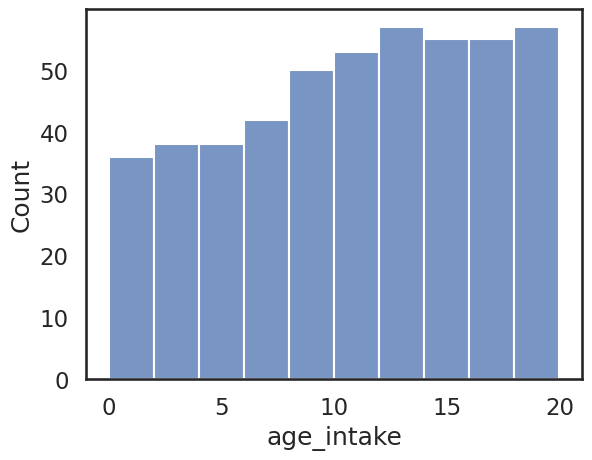

In [45]:
import seaborn as sns
sns.histplot(data = change_df["age_intake"], binwidth=2)

Observe, however, that aged, nursing, or pregnant dogs hardly have their outcome altered by having a name. Let's see what their predicted outcomes are:

In [46]:
abnormal_condition = full_df[full_df["Normal Condition"]==0]["predicts"].sum()/full_df.shape[0]
abnormal_named = 2*full_df[full_df["Normal Condition"]==0][full_df["Name_nan"]==0]["predicts"].sum()/full_df.shape[0]
abnormal_unnamed = 2*full_df[full_df["Normal Condition"]==0][full_df["Name_nan"]==1]["predicts"].sum()/full_df.shape[0]

print(f"Around {100*abnormal_condition:.2f}% of all animals in abnormal condition are predicted to have a positive outcome")
print(f"Around {100*abnormal_named:.2f}% of all animals in abnormal condition that have a name are predicted to have a positive outcome")
print(f"Around {100*abnormal_unnamed:.2f}% of all animals in abnormal condition that have no name are predicted to have a positive outcome")


Around 35.10% of all animals in abnormal condition are predicted to have a positive outcome
Around 70.21% of all animals in abnormal condition that have a name are predicted to have a positive outcome
Around 0.00% of all animals in abnormal condition that have no name are predicted to have a positive outcome


<ipython-input-46-e3d1c69273a8>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  abnormal_named = 2*full_df[full_df["Normal Condition"]==0][full_df["Name_nan"]==0]["predicts"].sum()/full_df.shape[0]
<ipython-input-46-e3d1c69273a8>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  abnormal_unnamed = 2*full_df[full_df["Normal Condition"]==0][full_df["Name_nan"]==1]["predicts"].sum()/full_df.shape[0]


Sadly, this paints a rather grim picture. Nursing, Pregnant, Aged, Feral, or Other-afflicted animals, i.e. all that were found in abnormal condition, have hardly a good forecast for adoption: roughly 35% of them are predicted to have a positive outcome. But if we split those groups by whether they have a name or not, we see that this makes a crass difference: *all* animals in abnormal state that are predicted to have a positive outcome do have a name. Whereas an animal in abnormal status and without a name is never predicted to have a positive outcome.
As a final, let's see how else we can make inference on this data. In particular, let's run a regression of all dummy-variables (and age) on the dummy that counts whether giving the synthetic animal a name would change their adoption outcome. This will show us which "comorbidities" have the biggest impact for making it less likely to be adopted if no name is given:

In [47]:

X_analysis = full_df.drop(["Name_nan", "predicts", "predicts_change", "change", "Intake Type_Owner Surrender", "Sex_Spayed Female"], axis = 1)
X_analysis["Abnormal Condition"] = 1 - X_analysis["Normal Condition"]
X_analysis = X_analysis.drop(["Normal Condition"], axis = 1)
import statsmodels.api as sm 
X_analysis = sm.add_constant(X_analysis)

for a in X_analysis.columns:
    X_analysis[a] = pd.to_numeric(X_analysis[a])

y_analysis = full_df["change"]

In [48]:
full_df.columns

Index(['Name_nan', 'age_intake', 'Normal Condition',
       'Intake Type_Owner Surrender', 'Intake Type_Public Assist',
       'Intake Type_Stray', 'Animal Type_Dog', 'Sex_Intact Female',
       'Sex_Intact Male', 'Sex_Neutered Male', 'Sex_Spayed Female', 'predicts',
       'predicts_change', 'change'],
      dtype='object')

So as not to fall in the dummy-trap, we set as a baseline-animal a owner-surrendered, spayed female in cat in normal condition.

In [49]:
from statsmodels.regression.linear_model import OLS


reg = OLS(endog = y_analysis, exog = X_analysis)



res = reg.fit()
print(res.summary())
print(f"A female spayed kitten surrendered by its owner in normal condition has baseline probability of {max(0,100*res.params[0]):.2f}% of having its outcome status negatively impacted when unnamed")
test_df = full_df[full_df["Animal Type_Dog"]==0][full_df["Normal Condition"]==1][full_df["Intake Type_Owner Surrender"]==1][full_df["age_intake"]==0][full_df["Sex_Spayed Female"]==1]["predicts"]
print(f"A female spayed kitten surrendered by its owner in normal condition has baseline probability of {test_df.sum()/test_df.shape[0]:.2f} of having a positive outcome.")

                            OLS Regression Results                            
Dep. Variable:                 change   R-squared:                       0.211
Model:                            OLS   Adj. R-squared:                  0.204
Method:                 Least Squares   F-statistic:                     31.71
Date:                Thu, 30 Mar 2023   Prob (F-statistic):           2.59e-44
Time:                        11:57:58   Log-Likelihood:                -606.64
No. Observations:                 960   AIC:                             1231.
Df Residuals:                     951   BIC:                             1275.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

<ipython-input-49-931ac2ae0b2a>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  test_df = full_df[full_df["Animal Type_Dog"]==0][full_df["Normal Condition"]==1][full_df["Intake Type_Owner Surrender"]==1][full_df["age_intake"]==0][full_df["Sex_Spayed Female"]==1]["predicts"]


In [50]:
coefficients = pd.DataFrame.from_dict({"Coefficients":res.params, "Standard Errors":res.HC0_se})
coefficients.drop("const", axis = 0, inplace=True)
coefficients.reset_index(inplace=True)
coefficients["index"] = ["Age","Public","Stray", "Dog", "Intact Female", "Intact Male", "Neutered Male", "Abnormal"]

<ipython-input-51-3e009b824770>:20: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.
  sns.scatterplot(x=pd.np.arange(coefficients.shape[0]),


<Figure size 640x480 with 0 Axes>

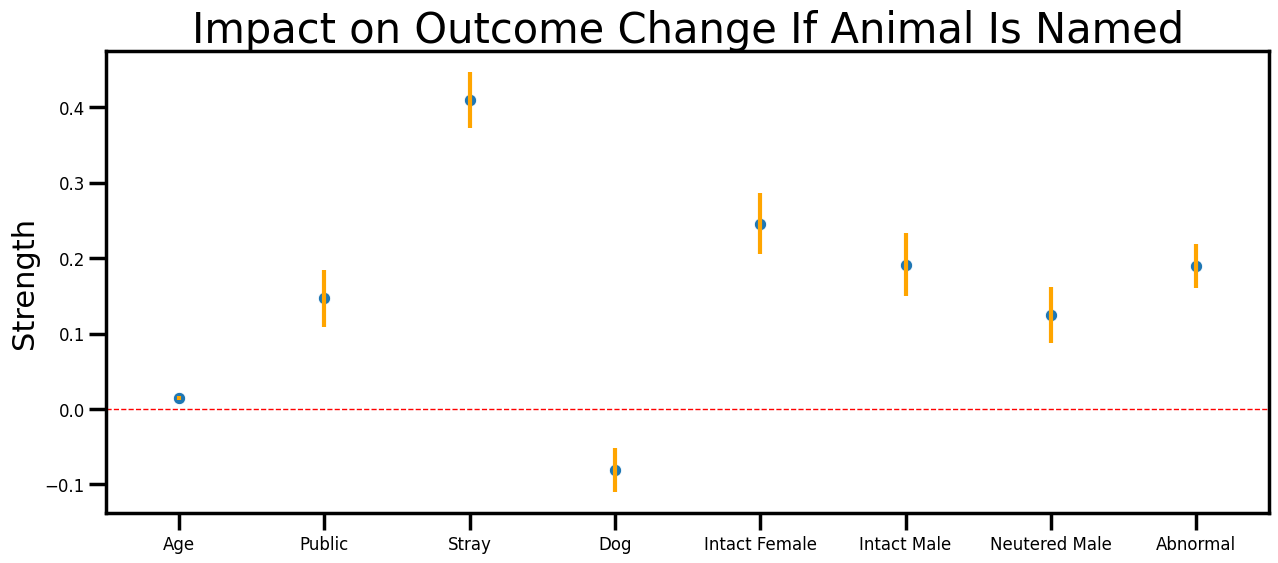

In [51]:
plt.clf()
sns.reset_defaults()
sns.set_context("poster")

    # Define figure, axes, and plot
fig, ax = plt.subplots(figsize=(15, 6))
    
    # Error bars for 95% confidence interval
coefficients.plot(x='index', y='Coefficients', kind='bar',
                 ax=ax, color='none', fontsize=12, 
                 ecolor='orange',capsize=0,
                 yerr='Standard Errors', legend=False)
    
    # Set title & labels
plt.title('Impact on Outcome Change If Animal Is Named',fontsize=30)
ax.set_ylabel('Strength',fontsize=22)
ax.set_xlabel('',fontsize=12)
    
    # Coefficients
sns.scatterplot(x=pd.np.arange(coefficients.shape[0]), 
               marker='o', s=80,
               y=coefficients['Coefficients'], legend = False)
    
    # Line to define zero on the y-axis
ax.axhline(y=0, linestyle='--', color='red', linewidth=1)
plt.xticks(rotation=0)
#plt.savefig('C:/Users/maggo/Desktop/Beatles Analysis/Robust_FE_Coefficients.png', dpi=300)
plt.show()


We see the same picture here as we found in the data earlier: the baseline says that giving an owner-surrendered, spayed female kitten in normal condition a name makes no change for her outcome - because she is already predicted to always face a positive outcome (good news for kittens!). However, it does make a big change for stray animals (+40%!), as well as for animals in normal condition (+19%), public-assist-surrendered animals (+15%), and sex-intact males and females alike (+20% / +25% each). Dogs also seem to profit slightly less from receiving a name, possibly due to their innate cuteness.

# 4 Conclusion

What can we learn from this project? Several things, I believe. First, we are able to predict very well based on just a few characteristics such as their sex, age, intake-types and -condition, as well as whether they have a name, whether a given animal is going to get adopted. Any classifier consistently scores above 90% accuracy, with the voting-classifier among an SVM, KNN, and a Random-Forest performing arguably the best.
Next, we also saw using these predictions on synthetic data that giving an animal a name very much impacts their chance for getting adopted. This pattern was especially pronounced for stray animals, perhaps because they become more adorable and personalized that way. Animals brought in in abnormal condition also stand a much better shot at getting adopted if named (in 20% of all conceivable cases it makes a difference to name them).
What can we learn from this? We have for sure not established any causality here: these shelters are all in Austin, TX, but they might, for example, be very heterogeneous. Some shelters might take excellent care of animals and are therefore able to provide most of them with a new home, whereas other shelters might not care about the animals and leave them behind. If that correlates with whether or not the animal is shown to have a name (which I believe it does), the last results are hardly a causal effect of giving an animal a name. Rather, it might just represent overall favourable conditions.
But is the possibility that naming animals might have an impact to be fully discarded? I do not think so. In particular, the cost of giving a nameless animal a name is virtually nil, and the effects, while possibly overstated, are likely to be at least a little bit positive. Therefore, this, I believe, gives good evidence that providing sheltered cats and dogs with names will increase their likelihood of facing a positive outcome. 
Now if you'll excuse me, I have to look at the nearest shelter for animals in abnormal condition, because my heart is breaking a little for them.